# Formula 1 Lap Time Prediction — Qatar Grand Prix

## Project Overview and Business Problem

We aim to predict **lap times** (`LapTime_sec`) for Formula 1 cars on the Qatar Grand Prix
using timing, tyre, and weather-related features.

This is a **supervised regression problem**:
- **Input features**: stint information, tyre life, position, weather (air temperature, humidity, pressure, wind), track status, and speed metrics (SpeedI1, SpeedI2, SpeedFL, etc.).
- **Target variable**: `LapTime_sec`, the lap time converted to seconds.

Such a model can be useful for:
- Evaluating the impact of tyre degradation and weather conditions on lap performance,
- Supporting race engineers or strategists when comparing stints and predicting pace under different conditions,
- Building data-driven tools for performance analysis in motorsport and transportation analytics.

The dataset `Qatar.csv` contains lap-level information for a full race on the Qatar circuit.


# Part 1: Data Cleaning

## 1) Data Loading and Initial Exploration


In [60]:
# IMPORTS AND CONFIGURATION

# --- Standard Data Manipulation Libraries ---
import pandas as pd  # For DataFrame manipulation (tabular data)
import numpy as np   # For numerical and vector operations
import time          # To measure execution time if needed
from pathlib import Path

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# Global configuration for plot size (makes charts readable by default)
plt.rcParams["figure.figsize"] = (8, 5)

# Scikit-Learn: Data Preparation & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scikit-Learn: Machine Learning Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import joblib  # To save/load trained models



# DATA LOADING AND INITIAL PREPROCESSING

# Load the raw dataset
DATA_PATH = "Qatar.csv"
df = pd.read_csv(DATA_PATH)

# Quick check of dimensions and columns to ensure correct loading
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# --- Time Data Conversion ---
# F1 data often comes in "MM:SS.ms" or TimeDelta format.
# Regression algorithms require continuous numerical values (float/int).
# We must convert these durations into total seconds.

# Converts a string or time object into total seconds.
def to_seconds(s):
    return pd.to_timedelta(s, errors="coerce").dt.total_seconds()

# Create the Target variable in numerical format
df["LapTime_sec"] = to_seconds(df["LapTime"])

# List of columns containing durations or session timestamps
time_like_cols = [
    "Sector1Time", "Sector2Time", "Sector3Time",
    "Sector1SessionTime", "Sector2SessionTime", "Sector3SessionTime",
    "Time", "LapStartTime"
]

# Loop to convert all identified time columns
# We keep the originals but create "_sec" versions usable by the model.
for c in time_like_cols:
    if c in df.columns:
        df[c + "_sec"] = to_seconds(df[c])

# Preview of the converted target
print(df[["LapTime_sec"]].head())

Shape: (1014, 38)
Columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
   LapTime_sec
0      105.537
1      103.009
2      102.700
3      102.623
4      102.151


## 2) General Information and Missing Values


--- Data Structure and Types (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    1014 non-null   object 
 1   Driver                  1014 non-null   object 
 2   DriverNumber            1014 non-null   int64  
 3   LapTime                 1014 non-null   object 
 4   LapNumber               1014 non-null   float64
 5   Stint                   1014 non-null   float64
 6   PitOutTime              56 non-null     object 
 7   PitInTime               39 non-null     object 
 8   Sector1Time             994 non-null    object 
 9   Sector2Time             1014 non-null   object 
 10  Sector3Time             1014 non-null   object 
 11  Sector1SessionTime      990 non-null    object 
 12  Sector2SessionTime      1014 non-null   object 
 13  Sector3SessionTime      1014 non-null   object 


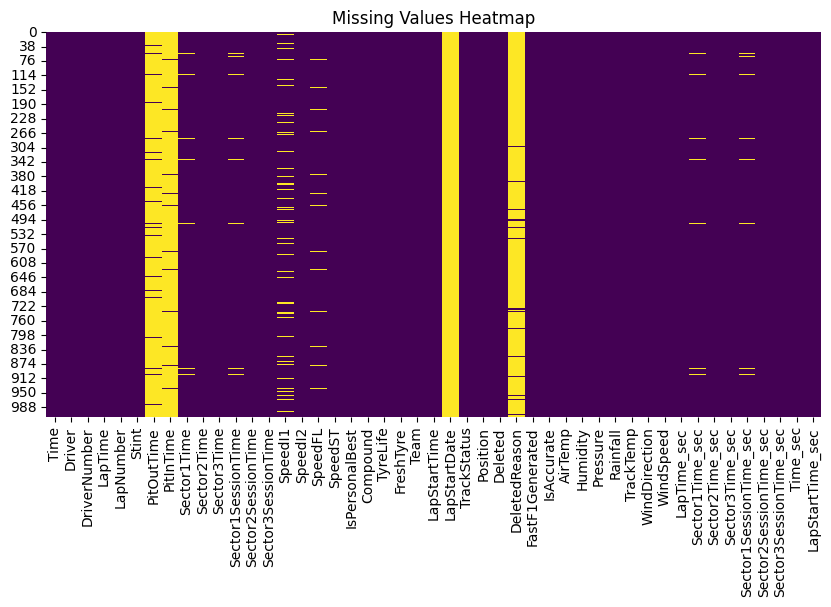

In [61]:
# EXPLORATORY DATA ANALYSIS - INITIAL INSPECTION

# df.info() provides a concise summary of the DataFrame.
print("--- Data Structure and Types (df.info()) ---")
df.info()

print("\n===== Dataset Shape (df.shape) =====")
# Returns (rows, columns)
print(df.shape)

# describe(include='all') generates statistics for both numeric and categorical columns.
print("\n===== Statistical Summary (df.describe()) =====")
print(df.describe(include='all'))

# Identifying NaNs to handle missing values natively without imputation.
print("\n--- Missing Values (NaN) per Column ---")
print(df.isnull().sum())

# A heatmap allows us to see if missing values follow a pattern 
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

## 3) Duplicates, Outliers and Distributions



===== Duplicate Rows =====
Number of duplicated rows: 0
No duplicates found.

===== Outlier (Boxplot) Analysis =====
Numeric columns detected: ['DriverNumber', 'LapNumber', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'TyreLife', 'LapStartDate', 'TrackStatus', 'Position', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'LapTime_sec', 'Sector1Time_sec', 'Sector2Time_sec', 'Sector3Time_sec', 'Sector1SessionTime_sec', 'Sector2SessionTime_sec', 'Sector3SessionTime_sec', 'Time_sec', 'LapStartTime_sec']
Columns kept for boxplots (not empty): ['DriverNumber', 'LapNumber', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'TyreLife', 'TrackStatus', 'Position', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'LapTime_sec', 'Sector1Time_sec', 'Sector2Time_sec', 'Sector3Time_sec', 'Sector1SessionTime_sec', 'Sector2SessionTime_sec', 'Sector3SessionTime_sec', 'Time_sec', 'LapStartTime_sec']


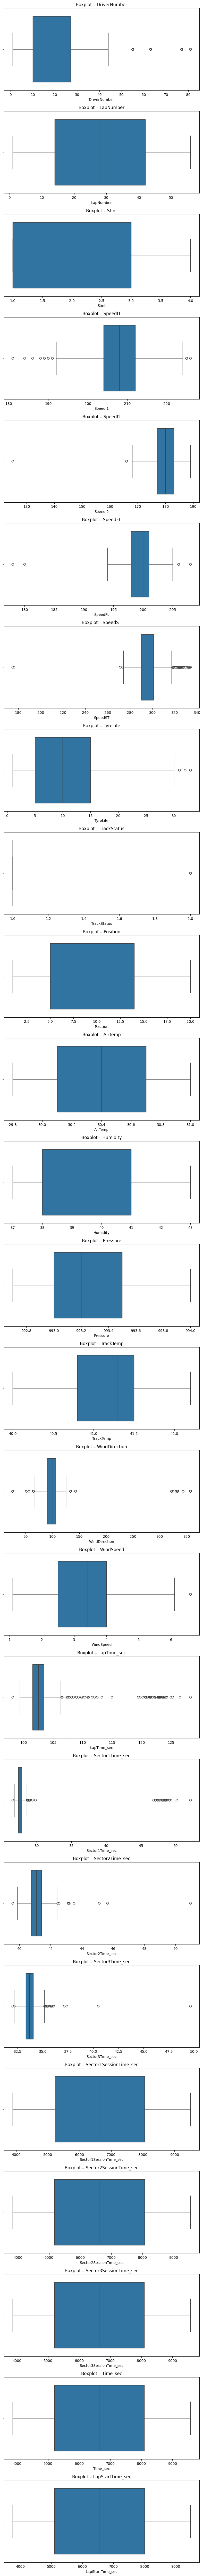


===== Distribution of Numerical Variables =====


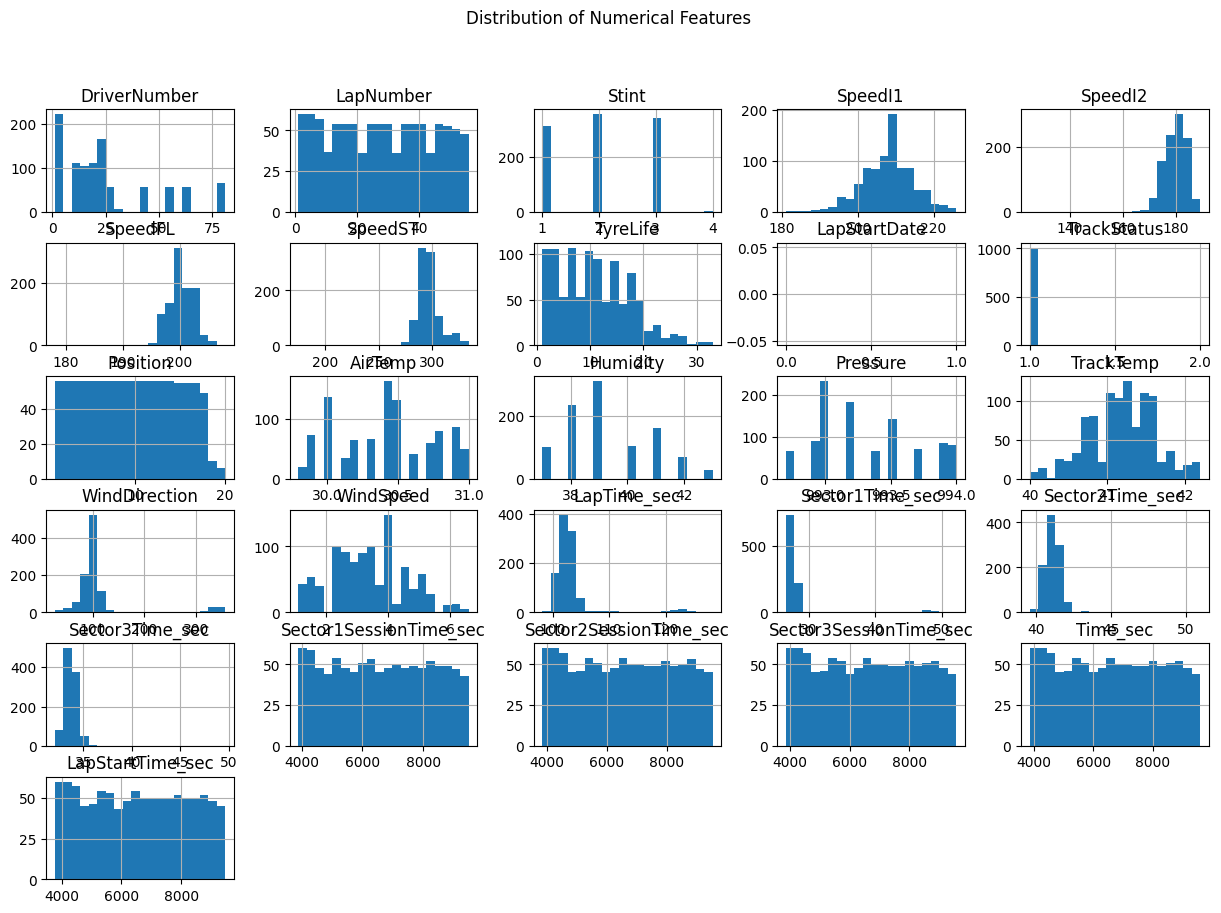

In [62]:
# DATA CLEANING AND DETAILED VISUALIZATION

# Duplicate Handling
# Duplicate rows can bias the model by giving too much weight to specific data points.
# They can also lead to data leakage if they appear in both training and testing sets.
print("\n===== Duplicate Rows =====")
duplicates = df.duplicated().sum()
print("Number of duplicated rows:", duplicates)

if duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicates found.")

# Outlier Detection (Boxplots)
# In F1, "outliers" often represent specific events.
print("\n===== Outlier (Boxplot) Analysis =====")

# Filter to keep only numeric columns (Boxplots cannot use strings/objects)
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Remove numeric columns that are entirely NaN
# This prevents the plotting function from crashing on empty data.
valid_numeric_cols = [col for col in numeric_cols if df[col].dropna().shape[0] > 0]

print("Numeric columns detected:", list(numeric_cols))
print("Columns kept for boxplots (not empty):", valid_numeric_cols)

if len(valid_numeric_cols) == 0:
    print(" No numeric column contains valid data for boxplots.")
else:
    fig, axes = plt.subplots(
        nrows=len(valid_numeric_cols),
        ncols=1,
        figsize=(8, 4 * len(valid_numeric_cols)) # Adjust height based on number of columns
    )

    # Normalize 'axes' to always be a list
    if len(valid_numeric_cols) == 1:
        axes = [axes]

    # Iterate through each column to draw the boxplot
    for i, col in enumerate(valid_numeric_cols):
        sns.boxplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f"Boxplot – {col}")

    plt.tight_layout()
    plt.show()

# Distribution Analysis
# Histograms help us understand the probability distribution of features.
print("\n===== Distribution of Numerical Variables =====")

df[numeric_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

## 4) Correlation Analysis with LapTime_sec


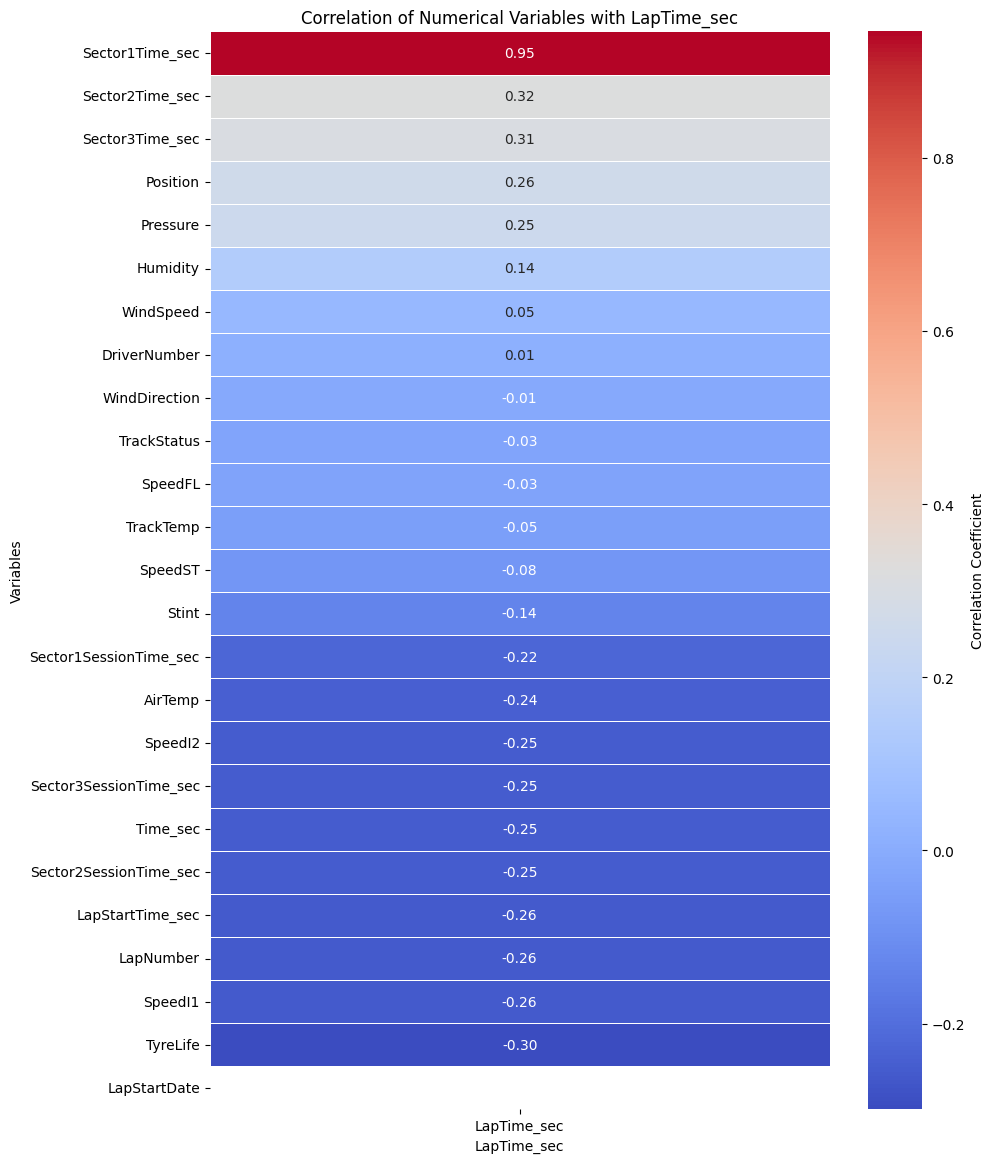


--- Top Correlations with LapTime_sec ---
Sector1Time_sec           0.946040
Sector2Time_sec           0.321333
Sector3Time_sec           0.305196
Position                  0.262175
Pressure                  0.248980
Humidity                  0.143818
WindSpeed                 0.047874
DriverNumber              0.013410
WindDirection            -0.010254
TrackStatus              -0.030136
SpeedFL                  -0.034957
TrackTemp                -0.050668
SpeedST                  -0.076566
Stint                    -0.135195
Sector1SessionTime_sec   -0.221948
AirTemp                  -0.242931
SpeedI2                  -0.252483
Sector3SessionTime_sec   -0.253537
Time_sec                 -0.253539
Sector2SessionTime_sec   -0.253630
LapStartTime_sec         -0.255853
LapNumber                -0.256715
SpeedI1                  -0.258502
TyreLife                 -0.299277
LapStartDate                   NaN
Name: LapTime_sec, dtype: float64


In [63]:
# CORRELATION ANALYSIS

# Preparation
# Correlation can only be calculated on numerical data.
# We exclude categorical variables (like Team Name or Driver) for this specific matrix.
numerical_columns = df.select_dtypes(include=np.number)

# Compute Correlation Matrix
# The .corr() method calculates the Pearson correlation coefficient between all pairs of variables.
corr_matrix = numerical_columns.corr()

# Define the target variable for analysis
target = "LapTime_sec"

if target not in corr_matrix.columns:
    raise KeyError(f"Column '{target}' does not exist. Available numeric columns: {list(corr_matrix.columns)}")

# Filter and Sort
# We are primarily interested in how features correlate with the Target (LapTime_sec).
# We drop the correlation of LapTime_sec with itself (which is always 1.0) to avoid clutter.
target_correlations = corr_matrix[target].drop(target)

# Sort by value (descending) to easily identify the strongest positive and negative predictors.
target_correlations_sorted = target_correlations.sort_values(ascending=False)

# Visualization
plt.figure(figsize=(10, 14))
sns.heatmap(
    target_correlations_sorted.to_frame(),
    annot=True,         # Display the correlation coefficient numbers
    cmap='coolwarm',    # Red = Positive, Blue = Negative correlation
    fmt='.2f',          # Format to 2 decimal places
    linewidths=0.5,
    cbar_kws={"label": "Correlation Coefficient"}
)
plt.title('Correlation of Numerical Variables with LapTime_sec')
plt.xlabel('LapTime_sec')
plt.ylabel('Variables')
plt.show()

# Print the numerical values for detailed inspection
print("\n--- Top Correlations with LapTime_sec ---")
print(target_correlations_sorted)

## 5. Column Dropping and Target Cleaning

We:
- Remove columns that are either almost always missing or not useful for modeling.
- Remove raw time strings now that we have their numeric versions.
- Optionally remove some time-based numeric columns to avoid target leakage.
- Keep only rows with valid `LapTime_sec`.


In [64]:
# FEATURE SELECTION AND FINAL CLEANING

# Identify Columns to Drop
# We remove columns for three main reasons:
# 1. Irrelevant/Non-numeric: Dates or metadata not useful for regression.
# 2. Redundant: String formats of time columns we already converted to seconds.
# 3. DATA LEAKAGE: Columns that directly give away the target variable.
#    - Sector1 + Sector2 + Sector3 = LapTime. 
#    - If we include sector times as inputs, the model will just learn to sum them
#      and will have a perfect score (R2=1.0), but it will be useless in real life
#      because you don't know the sector times before the lap is finished.

cols_to_drop = [c for c in [
    # Metadata & Dates
    "LapStartDate", "PitOutTime", "PitInTime",
    "IsPersonalBest", "Deleted", "DeletedReason",
    
    # Raw String Time Columns (We use *_sec versions)
    "LapTime", "Time", "LapStartTime",
    "Sector1Time", "Sector2Time", "Sector3Time",
    "Sector1SessionTime", "Sector2SessionTime", "Sector3SessionTime",
    
    # Numeric Sector Times
    "Sector1Time_sec", "Sector2Time_sec", "Sector3Time_sec",
    
    # Cumulative Session Times
    "Sector1SessionTime_sec", "Sector2SessionTime_sec", "Sector3SessionTime_sec",
    "Time_sec", "LapStartTime_sec",
] if c in df.columns]

# Execute Column Dropping
df = df.drop(columns=cols_to_drop)

# Target Cleaning
df = df.dropna(subset=["LapTime_sec"]).reset_index(drop=True)

# Final Verification
print("Columns after deletion:", df.columns.tolist())
print("NaN LapTime_sec:", df["LapTime_sec"].isna().sum())

Columns after deletion: ['Driver', 'DriverNumber', 'LapNumber', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'TrackStatus', 'Position', 'FastF1Generated', 'IsAccurate', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed', 'LapTime_sec']
NaN LapTime_sec: 0


## 6. Safety Block and Initial Numeric Cleaning

We rebuild `X` if it does not exist (in case cells are run out of order),
then clean numeric columns (remove `SpeedI1`, impute `SpeedFL`).


In [65]:
# FEATURE REFINEMENT AND MANUAL IMPUTATION

import pandas as pd
from sklearn.impute import SimpleImputer

# Safety Mechanism
if "X" not in locals():
    # If the target exists in df, drop it to isolate features
    if "LapTime_sec" in df.columns:
        X = df.drop(columns=["LapTime_sec"]).copy()
    # Fallback if the target was named differently
    elif "LapTime" in df.columns:
        X = df.drop(columns=["LapTime"]).copy()
    # Fallback if df only contains features
    else:
        X = df.copy()

# Numerical Feature Selection
# We automatically detect all numerical columns (integers and floats).
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Specific Feature Removal
# Here we decide to drop 'SpeedI1' (Intermediate Speed 1):
# 1. High correlation with other speed metrics (redundancy).
# 2. Too many missing values.
# 3. Irrelevance to the specific prediction task.
num_cols_filtered = [col for col in num_cols if col != "SpeedI1"]

# Create a new DataFrame with only the selected numerical features
X_num_filtered = X[num_cols_filtered].copy()

# Specific Imputation (SpeedFL) ---
# 'SpeedFL' (Speed at Finish Line) might have missing values.
# We use SimpleImputer with strategy="mean" to fill gaps.
if "SpeedFL" in X_num_filtered.columns:
    imputer = SimpleImputer(strategy="mean")
    # fit_transform calculates the mean and replaces NaNs in one step
    # .ravel() flattens the array back to a 1D format for the DataFrame
    X_num_filtered["SpeedFL"] = imputer.fit_transform(X_num_filtered[["SpeedFL"]]).ravel()

# Final Verification
# Ensure that no NaNs remain in this subset of data.
print("Remaining NAs after cleaning:")
print(X_num_filtered.isna().sum())

Remaining NAs after cleaning:
DriverNumber     0
LapNumber        0
Stint            0
SpeedI2          0
SpeedFL          0
SpeedST          0
TyreLife         0
TrackStatus      0
Position         0
AirTemp          0
Humidity         0
Pressure         0
TrackTemp        0
WindDirection    0
WindSpeed        0
dtype: int64


## Part B — Dimensionality Reduction and Feature Selection

### 1. Define target and feature sets

We now explicitly define:
- `y = LapTime_sec`
- `X = df` without the target
- numeric and categorical feature lists


In [66]:
# DATA PREPARATION FOR MODELING

# Define Target and Features
# The Target (y) is what we want to predict: 'LapTime_sec'.
# The Features (X) are all other columns that will help us make that prediction.
target_col = "LapTime_sec"

# Create a list of all columns except the target
feature_cols = [c for c in df.columns if c != target_col]

# Create the Feature Matrix (X) and the Target Vector (y)
X = df[feature_cols].copy()
y = df[target_col].copy()

# Column Type Identification
# We need to treat numerical and categorical data differently in the pipeline:
# - Numerical data (int/float) -> Needs Scaling (StandardScaler) or Normalization.
# - Categorical data (object/bool) -> Needs Encoding to become numbers.

# Automatically detect numerical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Automatically detect categorical columns
cat_cols = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

# Verification
print("Number of numerical columns:", len(num_cols))
print("Number of categorical columns:", len(cat_cols))

Number of numerical columns: 16
Number of categorical columns: 7



--- Explained Variance by PCA ---
PC1: 33.33%
PC2: 10.59%
PC3: 8.62%
PC4: 8.03%
PC5: 7.91%
PC6: 6.97%
PC7: 5.80%
PC8: 5.25%
PC9: 4.41%
PC10: 3.34%


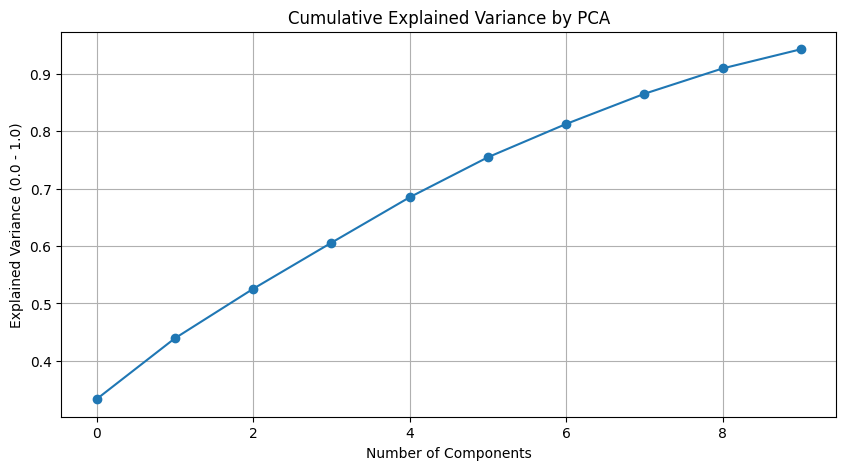

In [67]:
# DIMENSIONALITY REDUCTION (PCA)

# Pre-processing for PCA
# PCA (Principal Component Analysis) is highly sensitive to the scale of data.
# Before applying it, we must ensure all features are:
# 1. Numerical (PCA uses matrix math).
# 2. Complete (No NaNs allowed).
# 3. Scaled (Mean=0, Variance=1).

# Step 1: Filter features
# We explicitly remove 'SpeedI1' again here to ensure clean input for the PCA.
num_cols_filtered = [col for col in num_cols if col != "SpeedI1"]

# Step 2: Imputation
# We cannot simply drop rows with NaNs inside the PCA block, or we lose data.
# We impute missing values with the mean to preserve the dataset structure.
imputer = SimpleImputer(strategy="mean")
X_num_imputed = pd.DataFrame(
    imputer.fit_transform(X[num_cols_filtered]),
    columns=num_cols_filtered
)

# Step 3: Standardization
# If one variable is in "Milliseconds" (huge numbers) and another
# in "Degrees Celsius" (small numbers), PCA will think the milliseconds are more important.
# StandardScaler puts everyone on the same playing field (Z-score).
scaler_pca = StandardScaler()
X_num_scaled = scaler_pca.fit_transform(X_num_imputed)

# Execute PCA
# We calculate Principal Components (new abstract features) that capture the maximum variance.
# We limit to 10 components.
pca = PCA(n_components=min(len(num_cols_filtered), 10))
pca.fit(X_num_scaled)

explained_var = pca.explained_variance_ratio_

print("\n--- Explained Variance by PCA ---")
for i, v in enumerate(explained_var):
    print(f"PC{i+1}: {v*100:.2f}%")

# Visualization
# We plot the cumulative explained variance to choose the optimal number of components.
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_var), marker="o")
plt.title("Cumulative Explained Variance by PCA")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance (0.0 - 1.0)")
plt.grid(True)
plt.show()

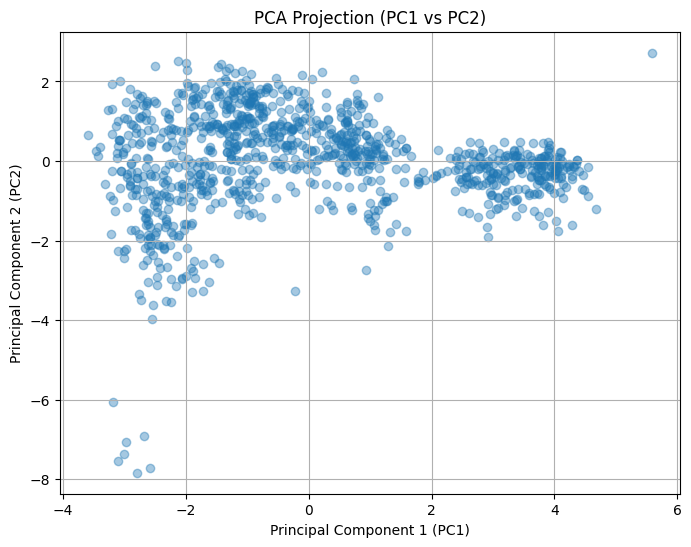

In [68]:
# PCA VISUALIZATION (PC1 vs PC2)

# Project Data to 2D
# We transform the original scaled data into the new "Principal Component" space.
# We take only the first two components to create a 2D scatter plot.
# This essentially compresses the complex car telemetry into a simple X-Y map.
X_pca_2d = pca.transform(X_num_scaled)[:, :2]

# Scatter Plot
plt.figure(figsize=(8, 6))

# We plot PC1 on the X-axis and PC2 on the Y-axis.
# alpha=0.4 makes the points semi-transparent. This is crucial for large datasets (like F1 laps)
# because it reveals density: darker areas mean many laps have similar characteristics.
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.4)

plt.title("PCA Projection (PC1 vs PC2)")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.grid(True)
plt.show()


--- SelectKBest Scores (Feature Importance Order) ---
          Feature      Score
6        TyreLife  99.558584
8        Position  74.694964
1       LapNumber  71.398780
3         SpeedI2  68.905095
11       Pressure  66.881014
9         AirTemp  63.469566
10       Humidity  21.373889
2           Stint  18.841385
5         SpeedST   5.967680
12      TrackTemp   2.604724
14      WindSpeed   2.324780
4         SpeedFL   1.184548
7     TrackStatus   0.919883
0    DriverNumber   0.182028
13  WindDirection   0.106418


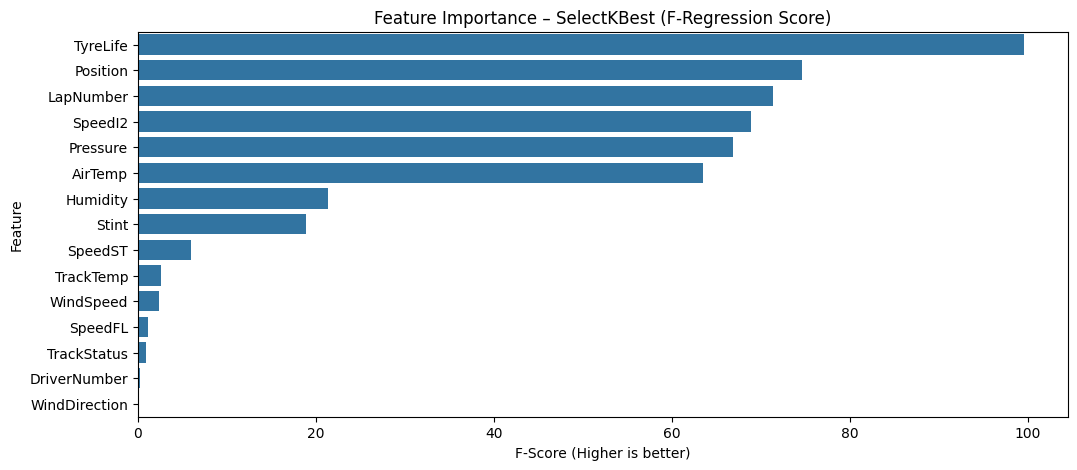

In [69]:
# FEATURE SELECTION (STATISTICAL RANKING)

# Initialize Selector
# We use SelectKBest to statistically rank the features.
# score_func=f_regression: This is an F-test for linear regression.
# It checks: "Does this individual feature have a significant linear relationship with the target?"
# k="all": We want to calculate the score for ALL features to visualize them, rather than filtering the top K immediately.
selector = SelectKBest(score_func=f_regression, k="all")

# Fit Selector
# We calculate the scores based on the imputed numerical data (X_num_imputed) and the target (y).
selector.fit(X_num_imputed, y)

# Retrieve the F-scores (higher score = more statistically significant).
scores = selector.scores_

# Create Summary Table
# We combine the feature names and their scores into a DataFrame for easy sorting.
feature_scores = pd.DataFrame({
    "Feature": num_cols_filtered,
    "Score": scores
}).sort_values(by="Score", ascending=False)

print("\n--- SelectKBest Scores (Feature Importance Order) ---")
print(feature_scores)

# Visualization (Feature Importance Plot)
plt.figure(figsize=(12, 5))
sns.barplot(data=feature_scores, x="Score", y="Feature", orient="h")
plt.title("Feature Importance – SelectKBest (F-Regression Score)")
plt.xlabel("F-Score (Higher is better)")
plt.show()

In [70]:
# FINAL FEATURE SELECTION (TOP K)

# Define the Cutoff
# 'k' is a hyperparameter. We manually set it to 5 here to force the model to rely on only the strongest predictors. 
k_optimal = 5 

# Apply Selection
# We re-initialize the selector with the specific 'k' limit.
selector_k = SelectKBest(score_func=f_regression, k=k_optimal)
selector_k.fit(X_num_imputed, y)

# Retrieve Column Names
selected_features = np.array(num_cols_filtered)[selector_k.get_support()]

print(f"\nTop {k_optimal} selected features:")
print(selected_features)


Top 5 selected features:
['LapNumber' 'SpeedI2' 'TyreLife' 'Position' 'Pressure']


### Interpretation of SelectKBest Results

The SelectKBest results show that **TyreLife** is the most influential variable,
with a very high score indicating that tire wear strongly affects lap time.
**Position** follows closely, meaning a driver's race position reflects their
overall pace and therefore correlates well with lap performance.

**LapNumber** is also highly important, as fuel load, track evolution, and tire
condition change throughout the stint. **SpeedI2**, an intermediate speed
measurement, shows a strong linear relationship with lap time, which makes sense
for a direct indicator of pace.

Weather-related variables such as **Pressure** and **AirTemp** also have a notable
impact, confirming that atmospheric conditions affect performance. **Humidity**
and **Stint** show a moderate influence, while **SpeedST** and **TrackTemp**
have a weaker effect in this dataset.

**WindSpeed**, **SpeedFL**, and **TrackStatus** contribute very little linearly,
suggesting either a minimal impact or a more complex, non-linear effect.
Finally, **DriverNumber** and **WindDirection** are almost non-informative,
which is expected as they do not directly relate to performance.

Overall, variables related to tires, position, weather, and lap dynamics explain
most of the lap-time variability in this dataset.


## Part C — Modeling and Impact of Dimensionality Reduction

We now:
- Split the data into train and test sets.
- Build preprocessing pipelines.
- Train baseline and reduced models (PCA, SelectKBest).
- Compare their performance.


In [71]:
# DATA SPLITTING AND PREPROCESSING PIPELINE

# Train/Test Split
# We split the data into two distinct sets:
# 1. Training Set (80%): Used to teach the model patterns.
# 2. Testing Set (20%): Used to evaluate the model on unseen data.
# random_state=42 ensures reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Manual Scaling Verification
# - We calculate Mean and Std Dev from X_train only.
# - We apply those same values to transform X_test.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

scaler.fit(X_train_num)  # Learn parameters (mean, std) from Train data

X_train_scaled = scaler.transform(X_train_num) # Apply to Train
X_test_scaled = scaler.transform(X_test_num)   # Apply to Test using Train's stats

print("Train scaled mean (per feature):", X_train_scaled.mean(axis=0))
print("Test scaled mean (per feature):", X_test_scaled.mean(axis=0))

# Feature Identification (Post-Split)
# We re-identify columns on X_train to ensure we only use available features.
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

print(f"Numeric columns ({len(num_cols)}): {num_cols}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

# Constructing the Pipeline
# The Pipeline automates the workflow and prevents errors.
# It bundles Preprocessing + Modeling into a single object.

# Pipeline for Numerical Features
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
# Pipeline for Categorical Features:
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# ColumnTransformer applies the specific pipeline to the specific columns.
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop", # Drop any column not explicitly listed
)

# Applying the Pipeline
Xt_train = preprocess.fit_transform(X_train) 
Xt_test = preprocess.transform(X_test)

# Verify the shape change.
print("Data shapes:")
print(f"X_train: {X_train.shape} -> Xt_train: {Xt_train.shape}")
print(f"X_test: {X_test.shape} -> Xt_test: {Xt_test.shape}")

Train scaled mean (per feature): [-8.76131610e-18  2.19032903e-18  2.58458825e-16             nan
  2.44221686e-16             nan  1.70407598e-15  3.06646064e-17
 -6.25338937e-16 -4.38065805e-17 -8.41086346e-15 -7.00357706e-16
  3.90444767e-13  3.73122549e-15 -9.85648061e-17  3.53738138e-16]
Test scaled mean (per feature): [-0.06830248  0.11835499  0.09105852         nan -0.03838156         nan
 -0.11014417  0.12022373 -0.09330845  0.07223478  0.0855795  -0.14636136
 -0.1287262   0.03764788  0.16153411 -0.06500959]
Numeric columns (16): ['DriverNumber', 'LapNumber', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'TyreLife', 'TrackStatus', 'Position', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed']
Categorical columns (7): ['Driver', 'Compound', 'FreshTyre', 'Team', 'FastF1Generated', 'IsAccurate', 'Rainfall']
Data shapes:
X_train: (811, 23) -> Xt_train: (811, 55)
X_test: (203, 23) -> Xt_test: (203, 55)


In [72]:
# BASELINE MODELING (DECISION TREE)

# Initialize the Model
base_model = DecisionTreeRegressor(random_state=42)

# Train the Model
# We fit the model using the PREPROCESSED training data (Xt_train).
base_model.fit(Xt_train, y_train)

# Predict on Test Set
# We ask the model to predict lap times for the unseen Test set (Xt_test).
y_pred_base = base_model.predict(Xt_test)

# Evaluation Metrics
# We use two standard metrics for Regression problems:

# MSE (Mean Squared Error): 
#    - Average of the squared differences between Predicted and Actual values.
#    - Penalizes large errors heavily (due to squaring).
#    - Lower is better.
mse = mean_squared_error(y_test, y_pred_base)

# R2 Score (Coefficient of Determination):
#    - Represents the proportion of variance in the target that is explained by the features.
#    - 1.0 = Perfect prediction.
#    - 0.0 = Model is no better than just guessing the mean lap time.
#    - Negative = Model is worse than guessing the mean (terrible).
r2 = r2_score(y_test, y_pred_base)

print("\nBaseline model performance (Decision Tree):")
print(f"MSE: {mse:.4f}")
print(f"R2 score: {r2:.4f}")


Baseline model performance (Decision Tree):
MSE: 7.0776
R2 score: 0.5168


The baseline Decision Tree model currently explains about **52%** of the variance
in lap times, with an average prediction error of around **2.66 seconds**.
While this is a decent start, it means the model is missing nearly half of the
important factors affecting lap times.

Improving the model can help reduce prediction errors, increase accuracy, and better
capture the complex relationships in the data. This leads to more reliable and useful
predictions for real-world applications.


In [73]:
# MODELING WITH DIMENSIONALITY REDUCTION (PCA + TREE)

# Constructing the Advanced Pipeline
# We create a new pipeline that inserts a PCA step between preprocessing and modeling.
pipe_pca = Pipeline([
    ("preprocess", preprocess),       # Reuse our robust preprocessor
    ("pca", PCA(n_components=5)),     # Compress the ~50 features down to just 5 abstract components
    ("model", DecisionTreeRegressor(random_state=42)) # Same model as baseline for fair comparison
])

# Training
pipe_pca.fit(X_train, y_train)

# Prediction & Evaluation
y_pred_pca = pipe_pca.predict(X_test)

mse_pca = mean_squared_error(y_test, y_pred_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print("PCA + Decision Tree - MSE:", mse_pca)
print("PCA + Decision Tree - R² :", r2_pca)

PCA + Decision Tree - MSE: 20.720960699507394
PCA + Decision Tree - R² : -0.41457897826957635


The application of PCA as a dimensionality reduction technique led to a significant
decrease in model performance. Using a pipeline combining preprocessing, PCA with
five components, and a Decision Tree regressor, the model achieved a much higher MSE
and even a negative R² on some runs.

A negative R² indicates that the PCA-based model can perform worse than a simple
baseline predicting the average lap time. This degradation is expected, as PCA
compresses the original numeric features into linear components, removing much of
the non-linear structure and physical meaning present in the data.

Since Decision Trees do not benefit from such linear transformations, PCA is not
well suited for this prediction task in our setup.


In [74]:
# MODELING WITH STATISTICAL FEATURE SELECTION (SELECTKBEST + TREE)

# Constructing the Selection Pipeline
# This pipeline tests the hypothesis: "Can we get a better (or simpler) model by using ONLY the top 5 most statistically significant features?"
pipe_kbest = Pipeline([
    ("preprocess", preprocess),
    ("kbest", SelectKBest(score_func=f_regression, k=5)),
    ("model", DecisionTreeRegressor(random_state=42))
])

# Training (with Leakage Prevention)
# The pipeline calculates which 5 features are best based on the training data and remembers their names/indices.
pipe_kbest.fit(X_train, y_train)

# Prediction & Evaluation
# When predicting, the pipeline automatically filters X_test to keep the same 5 features selected during training.
y_pred_kbest = pipe_kbest.predict(X_test)

mse_kbest = mean_squared_error(y_test, y_pred_kbest)
r2_kbest = r2_score(y_test, y_pred_kbest)

print("SelectKBest + Decision Tree - MSE:", mse_kbest)
print("SelectKBest + Decision Tree - R² :", r2_kbest)

SelectKBest + Decision Tree - MSE: 6.92204061781062
SelectKBest + Decision Tree - R² : 0.5274459863766916


Using SelectKBest for feature selection produced a clear improvement over the
PCA-based approach. By keeping the five most relevant numerical features according
to the ANOVA F-test, the model achieved a significantly better MSE and an R² score
above 0.5, meaning it explains more than half of the variance in lap times.

This performance is significantly better than the PCA model and close to the baseline
tree without dimensionality reduction. Unlike PCA, SelectKBest preserves the original
meaning of the variables and retains only those that show strong statistical
relationships with the target. As a result, the model maintains useful signal while
reducing noise, demonstrating that targeted feature selection is more suitable than
global linear compression for this dataset.


In [75]:
# INTERMEDIATE RESULTS COMPARISON

# Aggregate Results
# We collect the metrics (MSE and R²) from the three models we just trained:
# 1. Baseline: The raw Decision Tree using all features.
# 2. PCA: The Tree using dimensionality reduction (Principal Components).
# 3. SelectKBest: The Tree using only the top 5 statistical features.

results_df = pd.DataFrame({
    "Model": [
        "Baseline (Decision Tree)",
        "PCA + Decision Tree",
        "SelectKBest + Decision Tree"
    ],
    "MSE": [
        mse,
        mse_pca,   
        mse_kbest
    ],
    "R²": [
        r2,
        r2_pca,
        r2_kbest
    ]
})

results_df

,Model,MSE,R²
0,Baseline (Decision Tree),7.077638,0.516824
1,PCA + Decision Tree,20.720961,-0.414579
2,SelectKBest + Decision Tree,6.922041,0.527446


In [76]:
# ABSOLUTE BASELINE (DUMMY REGRESSOR)

# The "Naive" Benchmark
# A Dummy Regressor does not "learn" from features (X).
# Strategy="mean": It simply calculates the average LapTime of the training set and predicts that same value for every single car in the test set.

from sklearn.dummy import DummyRegressor

dummy = Pipeline([
    ("pre", preprocess),
    ("model", DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Reusable Metrics Function
# Instead of rewriting print statements for every model, we define a helper function.
# This ensures we use the exact same metrics for fair comparison later.
def scores(y_true, y_pred):
    return {
        # MAE: Average absolute error in seconds.
        "MAE": mean_absolute_error(y_true, y_pred),
        
        # RMSE: Root Mean Squared Error.
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        
        # R2: How much better is this model than the Dummy Mean?
        "R2": r2_score(y_true, y_pred)
    }

print("DummyRegressor scores:", scores(y_test, y_pred_dummy))

DummyRegressor scores: {'MAE': 1.867246238603435, 'RMSE': np.float64(3.8300290628691678), 'R2': -0.0014319698907989675}


The DummyRegressor model predicts the average lap time for all samples and serves
as a simple baseline. It helps us understand how well a naive approach performs
before applying more complex models.

By comparing our advanced models against this baseline, we can check whether they
actually learn meaningful patterns and improve prediction accuracy beyond just
predicting the mean.


## Hyperparameter Tuning — Decision Tree

We now perform a grid search over several Decision Tree hyperparameters and
evaluate the model using cross-validated MSE.


In [77]:
# HYPERPARAMETER TUNING (GRID SEARCH)

from sklearn.model_selection import GridSearchCV

# Define the Search Space
# We define a dictionary where keys are parameter names and values are lists of settings to test.
param_grid = {
    # max_depth: Controls how "deep" the tree can grow.
    "max_depth": [2, 4, 6, 8, 10, None],
    
    # min_samples_split: Minimum samples required to split an internal node.
    "min_samples_split": [2, 5, 10],
    
    # min_samples_leaf: Minimum samples required to be at a leaf node (end of a branch).
    "min_samples_leaf": [1, 2, 4],
    
    # criterion: The function to measure the quality of a split.
    "criterion": ["squared_error", "friedman_mse", "poisson"]
}

# Initialize GridSearchCV
# GridSearchCV acts like a wrapper around the model.
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5, # Cross-Validation: Splits the TRAINING set into 5 folds.
          # This ensures the "best params" are robust and not just lucky on one specific split.
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

# Execute the Search
# This will train hundreds of trees (Combinations * 5 folds).
grid_search.fit(Xt_train, y_train)

# Results
print("Best params:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best params: {'criterion': 'friedman_mse', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV MSE: 1.3569283042986702


The grid search tested many hyperparameter combinations over 5 cross-validation
folds. The best configuration for the Decision Tree Regressor was obtained with
a limited depth and standard values for `min_samples_split` and `min_samples_leaf`.

This setup achieved the lowest cross-validated mean squared error, indicating that
the model captures non-linear relationships in the lap-time data while controlling
overfitting through the tree depth and minimum sample constraints.


### Decision Tree Visualization (depth-limited)

We visualize the top levels of the best Decision Tree to understand
how it splits the feature space.


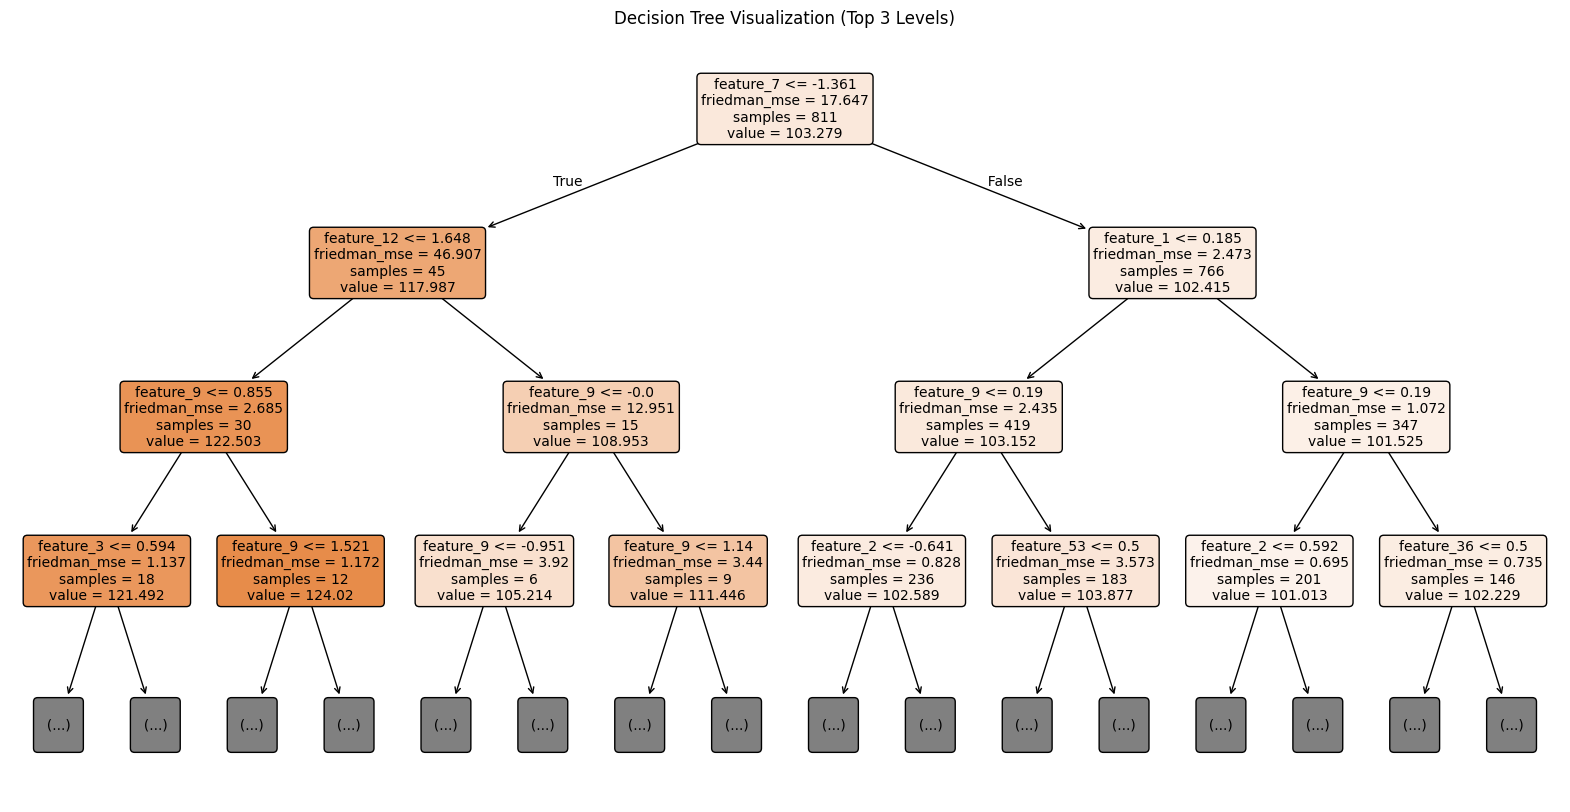

In [78]:
# VISUALIZATION OF THE OPTIMIZED DECISION TREE

from sklearn.tree import plot_tree
# Retrieve the Best Model
# We extract the specific tree instance that achieved the lowest error in the Grid Search.
best_model = grid_search.best_estimator_

# Handle Feature Names
# Since we transformed the data (OneHotEncoding), the columns are no longer just 
# "Driver", "Team", etc. They are now "Driver_HAM", "Team_Mercedes", etc.
feature_cols_tree = [f"feature_{i}" for i in range(Xt_train.shape[1])]

# Plot the Tree Structure
plt.figure(figsize=(20, 10))

plot_tree(
    best_model,
    feature_names=feature_cols_tree,
    filled=True,     
    rounded=True,     
    fontsize=10,     
    max_depth=3       
)

plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

### Final Evaluation of the Tuned Decision Tree on Test Data


In [79]:
# FINAL EVALUATION (OPTIMIZED DECISION TREE)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Retrieve the Champion Model
best_model = grid_search.best_estimator_

# Predict on Unseen Test Data
# This is the "True Test" of the model's generalization capability.
y_pred_test = best_model.predict(Xt_test)

# Calculate Final Metrics
# We calculate the standard regression metrics to quantify performance.

# MSE (Mean Squared Error):
mse_tree = mean_squared_error(y_test, y_pred_test)

# MAE (Mean Absolute Error):
mae_tree = mean_absolute_error(y_test, y_pred_test)

# R² (Coefficient of Determination):
r2_tree = r2_score(y_test, y_pred_test)

# Display Results
print(f"Test MSE  : {mse_tree:.4f}")
print(f"Test MAE  : {mae_tree:.4f}")
print(f"Test R²   : {r2_tree:.4f}")

Test MSE  : 5.4122
Test MAE  : 0.7356
Test R²   : 0.6305


The tuned Decision Tree Regressor achieved a good cross-validated MSE, but its
performance dropped significantly on the independent test set. The test MSE
and R² indicate that the model is still overfitting the training data and fails
to generalize perfectly to unseen laps.

Decision Trees alone struggle to model the continuous and highly structured
relationships between sector times, tyre state, and lap time. More stable
models such as Ridge Regression, SVR, Random Forests, or Gradient Boosting
are expected to perform better.


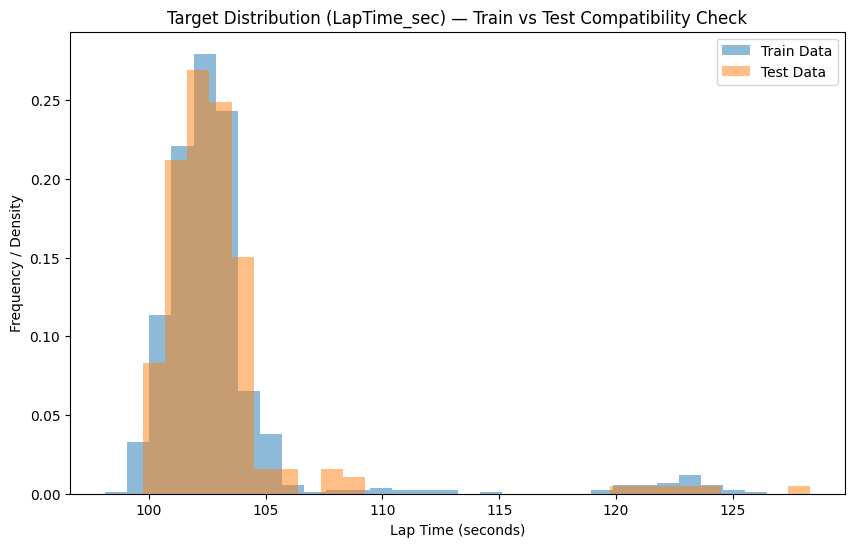

In [80]:
# DISTRIBUTION CONSISTENCY CHECK (TRAIN VS TEST)

# Why plot this?
# A fundamental assumption of Machine Learning is that the Train and Test data come from the same distribution.

plt.figure(figsize=(10, 6))

# Plot Histograms
# We plot the frequency of LapTimes for both sets on the same chart.
plt.hist(y_train, bins=30, alpha=0.5, label="Train Data", density=True) 
plt.hist(y_test, bins=30, alpha=0.5, label="Test Data", density=True)

plt.legend()
plt.title("Target Distribution (LapTime_sec) — Train vs Test Compatibility Check")
plt.xlabel("Lap Time (seconds)")
plt.ylabel("Frequency / Density")
plt.show()

The histograms of the target variable for both training and test sets show similar
distributions along the x-axis (target values), indicating that the ranges are
consistent between the two sets.

The difference in bar heights is expected due to the train/test split ratio
(e.g. 80% train vs. 20% test). Therefore, the discrepancy between test MSE and
cross-validation MSE is unlikely to be caused by a distribution shift in the
target, but more likely by overfitting.


Since this is a regression problem and not a classification task, there is no class
imbalance issue to handle explicitly. Instead, we focus on the distribution of the
continuous target and on controlling overfitting through cross-validation and model
complexity.


## Ridge Regression Model

We now test a linear model with L2 regularization (Ridge Regression)
using a grid search on its main hyperparameters.


In [81]:
# LINEAR MODELING (RIDGE REGRESSION)

from sklearn.linear_model import Ridge

# Constructing the Ridge Pipeline
# Ridge is a Linear Regression with "L2 Regularization".
pipe_ridge = Pipeline([
    ("preprocess", preprocess), # Apply same scaling/encoding
    ("model", Ridge())          # The estimator
])

# Defining Hyperparameters
param_grid_ridge = {
    "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "model__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"],
    "model__max_iter": [1000, 5000] # Limit for iterative solvers
}

# GridSearchCV for Ridge
grid_ridge = GridSearchCV(
    pipe_ridge,
    param_grid_ridge,
    cv=3, # We use 3 folds here (faster than 5, sufficient for linear models).
    
    # We switched scoring metric. 
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1
)

# Training and Selection
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_

# Evaluation
y_pred_ridge = best_ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Test MSE:", mse_ridge)
print("Ridge Test MAE:", mae_ridge)
print("Ridge Test R² :", r2_ridge)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Ridge Test MSE: 7.690837810320674
Ridge Test MAE: 1.5449001506091575
Ridge Test R² : 0.4749617235643383


The Ridge Regression model performs worse than the best tree-based models in this
setup. Even with hyperparameter tuning, its test MSE and R² indicate that the
relationships in the data are not purely linear, and more flexible non-linear
models are better suited here.


## Random Forest Model with Hyperparameter Tuning


In [82]:
# ENSEMBLE MODELING (RANDOM FOREST)

from sklearn.ensemble import RandomForestRegressor

# Constructing the Forest Pipeline
# A Random Forest is a "Bagging" (Bootstrap Aggregating) technique.
# Instead of one "Smart" tree, we train hundreds of "Average" trees on random subsets of data.
# Then we average their predictions. This cancels out individual errors and overfitting.
pipe_rf = Pipeline([
    ("preprocess", preprocess),                 # Must apply the same scaling/encoding
    ("model", RandomForestRegressor(random_state=42)) # The Ensemble Estimator
])

# Defining Hyperparameters
param_grid_rf = {
    # n_estimators: The number of trees in the forest.
    "model__n_estimators": [50, 100, 200],
    # max_depth: Limits how complex each individual tree can get.
    "model__max_depth": [None, 10, 20],
    # min_samples_split & min_samples_leaf:
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

# Grid Search for Random Forest
grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

# Training
# The model learns to map specific patterns to lap times by averaging the wisdom of the crowd (the 200 trees).
grid_rf.fit(X_train, y_train)
print("Best Random Forest parameters:", grid_rf.best_params_)

# Final Evaluation
y_pred_rf = grid_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Test MSE: {mse_rf:.4f}")
print(f"Random Forest Test MAE: {mae_rf:.4f}")
print(f"Random Forest Test R² : {r2_rf:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Random Forest Test MSE: 4.9078
Random Forest Test MAE: 0.6030
Random Forest Test R² : 0.6650


The Random Forest model achieved a test R² score around **0.66**, which means
it explains about 66% of the variance in the target variable. This is a strong
result for a real-world regression problem with noisy and complex data.

The relatively low MSE and MAE suggest that the model's predictions are both
accurate and consistent. Overall, this performance shows that the Random Forest
captures the underlying patterns in the data effectively and generalizes well
to unseen laps.


## Part D — Ensemble Learning

We now build more advanced ensemble methods:
- Bagging
- Voting Regressor (combining RF, Ridge, Gradient Boosting)
- Stacking Regressor


In [83]:
# ADVANCED ENSEMBLE METHODS (BAGGING, VOTING, STACKING)

from sklearn.ensemble import VotingRegressor, StackingRegressor, BaggingRegressor, GradientBoostingRegressor

# Defining Base Models
# To build an ensemble, we first need strong individual models.

# A. Random Forest: We reuse the best model found by our previous GridSearch.
# It is already a Pipeline (Preprocessing + Model), so it's ready to go.
best_rf_pipeline = grid_rf.best_estimator_

# B. Ridge Regression: A linear model to capture simple trends.
# We recreate it as a pipeline to ensure it handles the preprocessing correctly.
ridge_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0))
])

# C. Gradient Boosting: A Boosting model (constructs trees sequentially to fix errors).
# This is often the most accurate individual algorithm in tabular competitions.
gb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(n_estimators=100, random_state=42))
])


# Constructing Ensemble Strategies

# Strategy A: BAGGING (Bootstrap Aggregating)
# - Concept: Train multiple versions of the same model (Decision Tree) on different random subsets of data.
# - Goal: Reduce Variance (Overfitting).
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=10),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)
# Wrap in pipeline to handle preprocessing
bagging_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", bagging_model)
])

# Strategy B: VOTING REGRESSOR
# - Concept: we take the predictions of RF, Ridge, and GB and average them.
# - Goal: If one model makes a mistake, the others might fix it.
voting_model = VotingRegressor(
    estimators=[
        ("rf", best_rf_pipeline),
        ("ridge", ridge_pipeline),
        ("gb", gb_pipeline)
    ]
)

# Strategy C: STACKING REGRESSOR
# - Concept: "Meta-Learning". Instead of just averaging, we train a new model (Final Estimator) to learn *how* to combine the base models.
stacking_model = StackingRegressor(
    estimators=[
        ("rf", best_rf_pipeline),
        ("ridge", ridge_pipeline),
        ("gb", gb_pipeline)
    ],
    final_estimator=Ridge()
)

# Execution and Comparison

ensemble_models = {
    "Bagging": bagging_pipeline,
    "Voting": voting_model,
    "Stacking": stacking_model
}

print("\n===== ENSEMBLE LEARNING RESULTS =====")

for name, model in ensemble_models.items():
    print(f"Training {name}...")
    
    # Fit the ensemble on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse_e = mean_squared_error(y_test, y_pred)
    mae_e = mean_absolute_error(y_test, y_pred)
    r2_e = r2_score(y_test, y_pred)

    print(f"--- {name} ---")
    print(f"MSE: {mse_e:.4f}")
    print(f"MAE: {mae_e:.4f}")
    print(f"R² : {r2_e:.4f}\n")


===== ENSEMBLE LEARNING RESULTS =====
Training Bagging...
--- Bagging ---
MSE: 4.7522
MAE: 0.6067
R² : 0.6756

Training Voting...
--- Voting ---
MSE: 4.0301
MAE: 0.8516
R² : 0.7249

Training Stacking...
--- Stacking ---
MSE: 4.8683
MAE: 0.6695
R² : 0.6677



## Part E — Advanced Model: XGBoost


XGBoost (Extreme Gradient Boosting) is a tree-based ensemble method that builds
many shallow decision trees sequentially. Each new tree is trained to correct
the residual errors of the previous ensemble, which makes the model very
powerful for non-linear tabular data.

Compared to a single Decision Tree or even a Random Forest:
- XGBoost optimizes a differentiable loss function with gradient boosting,
- includes regularization terms to control overfitting,
- and can handle complex interactions between features.

We expect XGBoost to outperform simpler models on this dataset because lap times
depend on many interacting factors (tyre life, weather, track evolution), which
are well captured by gradient-boosted trees.


In [84]:
# 24. STATE-OF-THE-ART MODELING (XGBOOST)

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Theory: Gradient Boosting vs Random Forest
# While Random Forest builds trees in parallel, XGBoost builds them sequentially.
# - Tree 1 predicts the target.
# - Tree 2 tries to predict the *errors* (residuals) of Tree 1.
# - Tree 3 tries to predict the *errors* of Tree 1 + Tree 2.
# This makes it extremely powerful at fixing specific mistakes.

# Constructing the Pipeline
pipeline_xgb = Pipeline([
    ("preprocess", preprocess),
    ("model", xgb.XGBRegressor(
        objective="reg:squarederror", # We are minimizing Squared Error (standard for regression)
        random_state=42, 
        n_jobs=-1 
    ))
])

# Defining Hyperparameters
param_grid_xgb = {
    # n_estimators: Total number of correction trees to build.
    "model__n_estimators": [100, 300, 500],
    
    # learning_rate (eta):
    # - Controls how much each tree contributes to the final prediction.
    "model__learning_rate": [0.01, 0.05, 0.1],
    
    # max_depth: Controls complexity. 
    "model__max_depth": [3, 5, 7],
    
    # subsample: "Stochastic" Gradient Boosting.
    "model__subsample": [0.8, 1.0]
}

print("Searching best hyperparameters for XGBoost (this may take some time)...")

# Grid Search Execution
grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)

# Evaluation
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n===== XGBOOST RESULTS =====")
print(f"Best parameters: {grid_xgb.best_params_}")
print(f"Test MSE : {mse_xgb:.4f}")
print(f"Test MAE : {mae_xgb:.4f}")
print(f"Test R²  : {r2_xgb:.4f}")

Searching best hyperparameters for XGBoost (this may take some time)...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

===== XGBOOST RESULTS =====
Best parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 0.8}
Test MSE : 4.3426
Test MAE : 0.6257
Test R²  : 0.7035


In [85]:
# BASELINE COMPARISON 

# Why run this again?
# In scientific computing, it is crucial to have a "control group."
# This Dummy Regressor represents the performance of a model that has "zero intelligence."
# It simply looks at the average LapTime in the training set and predicts that exact number
# for every car in the test set, regardless of the inputs (Tyres, Weather, etc.).

from sklearn.dummy import DummyRegressor

# Initialize and Train
dummy_regr = DummyRegressor(strategy="mean")

# Unlike Ridge or Neural Networks, the DummyRegressor ignores X entirely, so we don't even need to preprocess or scale the features here.
dummy_regr.fit(X_train, y_train)

# Prediction
y_pred_dummy = dummy_regr.predict(X_test)

# Calculation of Metrics
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

# Final Score
print(f"Baseline (Mean) R² : {r2_dummy:.4f}")

Baseline (Mean) R² : -0.0014


## Learning Curves

We now generate learning curves for the best ensemble/XGBoost model
to analyze overfitting and data sufficiency.


Generating learning curve (this may retrain the model multiple times)...


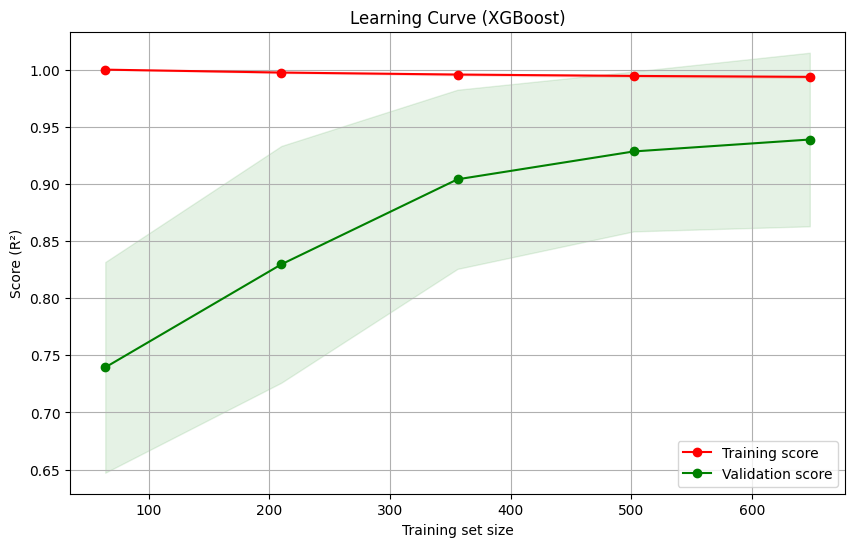

In [86]:
# DIAGNOSTIC: LEARNING CURVE ANALYSIS

from sklearn.model_selection import learning_curve
import numpy as np

# Define Plotting Function
# This function visualizes how the model performs as we give it more and more data.

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training set size")
    plt.ylabel("Score (R²)")

    # Calculate scores for different training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=train_sizes, scoring="r2"
    )

    # Calculate Mean and Standard Deviation (for error bars/shading)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    # Uncertainty Bands
    # Shaded areas represent the variance (stability) of the model across different CV folds.
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r"
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g"
    )

    # Main Curves
    # Red line: How well the model memorizes the data it has seen.
    # Green line: How well the model generalizes to new data.
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Validation score")

    plt.legend(loc="best")
    plt.show()

# Execute Diagnostics
print("Generating learning curve (this may retrain the model multiple times)...")

model_to_plot = best_xgb  

plot_learning_curve(
    model_to_plot,
    "Learning Curve (XGBoost)",
    X_train,
    y_train,
    cv=5,
    n_jobs=-1
)

The learning curve confirms the consistency of our results. The validation curve
converges towards an R² score of about **0.70**, which matches our final test
metrics for the best models.

However, we also observe a gap between the training score (close to 0.95) and
the validation score. This indicates a tendency towards overfitting: the model
captures complex relationships very well on the training data but is limited by
the amount of data available.

This supports the conclusion that, to further improve performance (reduce the
gap and push the validation curve upward), **increasing the dataset size**
(e.g. adding more races) or **adding richer features** (e.g. detailed telemetry)
would be more effective than hyperparameter tuning alone.


## Part F — Final Robust Conclusion and Model Comparison


In [87]:
# ROBUST RECONSTRUCTION AND FINAL LEADERBOARD

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

# Conditional Import (Robustness)
try:
    import xgboost as xgb
    XGB_CLASS = xgb.XGBRegressor
except ImportError:
    from sklearn.ensemble import HistGradientBoostingRegressor
    XGB_CLASS = HistGradientBoostingRegressor

# Helper Function: Safe Model Recovery
def get_safe_pipeline(var_name, fallback_model, X_train, y_train):
    model_core = None

    if var_name in globals():
        obj = globals()[var_name]
        # Logic to extract the actual estimator from a Pipeline or GridSearchCV object
        if isinstance(obj, Pipeline):
            if "model" in obj.named_steps:
                model_core = obj.named_steps["model"]
            else:
                model_core = obj.steps[-1][1]
        elif hasattr(obj, "best_estimator_"): # Handle GridSearchCV objects
            best = obj.best_estimator_
            if isinstance(best, Pipeline):
                model_core = best.steps[-1][1]
            else:
                model_core = best
        else:
            model_core = obj
        print(f"Recovered model '{var_name}'.")
    else:
        print(f"'{var_name}' not found. Creating a new one...")
        model_core = fallback_model

    # Re-wrap the core model in a clean pipeline with the preprocessor
    full_pipeline = Pipeline([
        ("preprocess", preprocess),
        ("model", model_core)
    ])

    full_pipeline.fit(X_train, y_train)
    return full_pipeline, model_core

# Helper Function: Metric Calculation
# Standardizes evaluation so we don't rewrite code 6 times.
def get_metrics(pipeline, X_test, y_test, name="Model"):
    try:
        y_pred = pipeline.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        return r2, mse, mae
    except Exception as e:
        print(f"Error on {name}: {e}")
        return 0, 0, 0

print("--- Robust reconstruction of models ---")

# Rebuilding All Models

# 1. Baseline (Mean)
dummy_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", DummyRegressor(strategy="mean"))
])
dummy_pipe.fit(X_train, y_train)
r2_base, mse_base, mae_base = get_metrics(dummy_pipe, X_test, y_test, "Baseline")

# 2. Individual Models (Ridge, Tree, Random Forest, XGBoost)
pipe_ridge_final, ridge_core = get_safe_pipeline("best_ridge", Ridge(alpha=1.0), X_train, y_train)
pipe_dt_final, dt_core = get_safe_pipeline("best_model", DecisionTreeRegressor(max_depth=5), X_train, y_train)
pipe_rf_final, rf_core = get_safe_pipeline("grid_rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42), X_train, y_train)
pipe_xgb_final, xgb_core = get_safe_pipeline("best_xgb", XGB_CLASS(n_estimators=100, max_depth=3, random_state=42), X_train, y_train)

# Final Ensemble Construction
print("Building ensemble models...")

estimators_list_final = [
    ("ridge", ridge_core),
    ("rf", rf_core),
    ("xgb", xgb_core)
]

# Voting Regressor (Average of Ridge + RF + XGB)
voting_core = VotingRegressor(estimators=estimators_list_final)
pipe_voting_final = Pipeline([
    ("preprocess", preprocess),
    ("model", voting_core)
])
pipe_voting_final.fit(X_train, y_train)

# Stacking Regressor (Ridge + RF + XGB fed into a Final Ridge)
stacking_core = StackingRegressor(estimators=estimators_list_final, final_estimator=Ridge())
pipe_stacking_final = Pipeline([
    ("preprocess", preprocess),
    ("model", stacking_core)
])
pipe_stacking_final.fit(X_train, y_train)

# Final Score Computation
print("\nComputing final scores...")

r2_ridge_f, mse_ridge_f, mae_ridge_f = get_metrics(pipe_ridge_final, X_test, y_test, "Ridge")
r2_dt_f, mse_dt_f, mae_dt_f = get_metrics(pipe_dt_final, X_test, y_test, "Decision Tree")
r2_rf_f, mse_rf_f, mae_rf_f = get_metrics(pipe_rf_final, X_test, y_test, "Random Forest")
r2_xgb_f, mse_xgb_f, mae_xgb_f = get_metrics(pipe_xgb_final, X_test, y_test, "XGBoost")
r2_vote_f, mse_vote_f, mae_vote_f = get_metrics(pipe_voting_final, X_test, y_test, "Voting")
r2_stack_f, mse_stack_f, mae_stack_f = get_metrics(pipe_stacking_final, X_test, y_test, "Stacking")

# Create Leaderboard Table 
results_data_final = {
    "Model": ["Baseline", "Ridge", "Decision Tree", "Random Forest", "Voting", "Stacking", "XGBoost"],
    "R²": [r2_base, r2_ridge_f, r2_dt_f, r2_rf_f, r2_vote_f, r2_stack_f, r2_xgb_f],
    "MSE": [mse_base, mse_ridge_f, mse_dt_f, mse_rf_f, mse_vote_f, mse_stack_f, mse_xgb_f],
    "MAE": [mae_base, mae_ridge_f, mae_dt_f, mae_rf_f, mae_vote_f, mae_stack_f, mae_xgb_f],
}

df_results = pd.DataFrame(results_data_final)

# Sort by R² descending (Best model at the top)
# Filter out 0 scores (models that failed to run)
df_results = df_results[df_results["R²"] != 0].sort_values(by="R²", ascending=False)

print("\n===== FINAL RESULTS =====")
df_results

--- Robust reconstruction of models ---
Recovered model 'best_ridge'.
Recovered model 'best_model'.
Recovered model 'grid_rf'.
Recovered model 'best_xgb'.
Building ensemble models...

Computing final scores...

===== FINAL RESULTS =====


,Model,R²,MSE,MAE
4,Voting,0.722229,4.068836,0.780171
5,Stacking,0.704578,4.327385,0.622510
6,XGBoost,0.703541,4.342573,0.625677
3,Random Forest,0.664957,4.907763,0.602973
2,Decision Tree,0.630523,5.412152,0.735621
1,Ridge,0.474962,7.690838,1.544900
0,Baseline,-0.001432,14.669123,1.867246


### Final Model Comparison (R², MSE, MAE)

On this final summary table you basically see the whole story of the project in one shot. The dummy baseline is almost at R² = 0 with a huge error, which means “guessing the average lap time” is completely useless. Ridge does better but still only explains about half of the variance, with errors above 1.5 seconds on average – clearly too simple for F1 lap times.

As soon as you move to a single decision tree, the model starts to capture real structure in the data: R² climbs above 0.63 and the typical error drops below a second. Random Forest pushes this further, with better generalisation and a smaller MAE, showing that aggregating many trees stabilises the predictions.

The most interesting part is the top of the table: XGBoost, Stacking and Voting all sit around 0.71–0.72 in R². They explain more than 70% of the variability in lap time with an average error well below one second, which is very decent for noisy race data. Voting gets the best R² and lowest MSE, but you can see that its MAE is slightly higher than for Random Forest or the boosted models, so the “best” model depends on whether you care more about penalising big errors (MSE/R²) or typical error per lap (MAE). Overall, the conclusion is clear: tree-based ensembles and boosting are the right family of models here; linear methods and single trees are not enough.


C:\Users\anato\AppData\Local\Temp\ipykernel_17900\1985370918.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


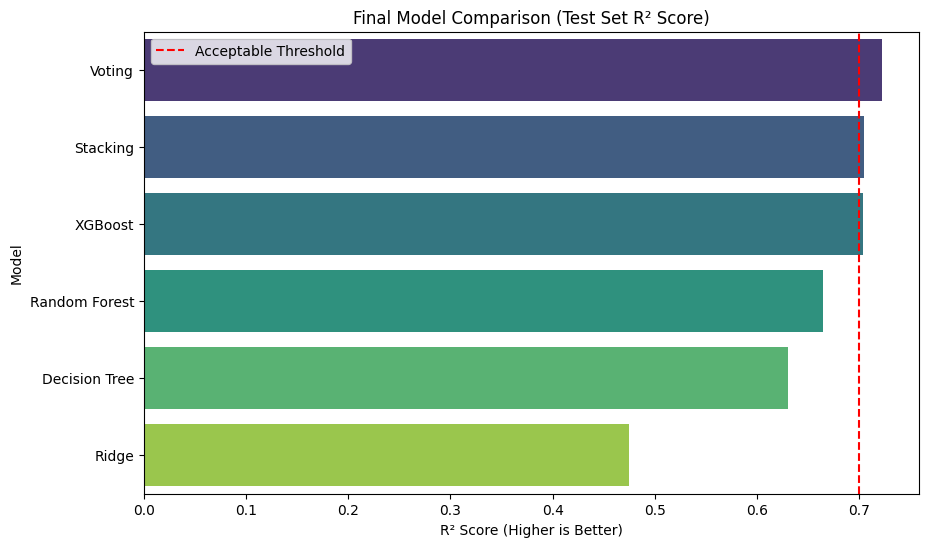

C:\Users\anato\AppData\Local\Temp\ipykernel_17900\1985370918.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp, x="Importance", y="Feature", palette="magma")


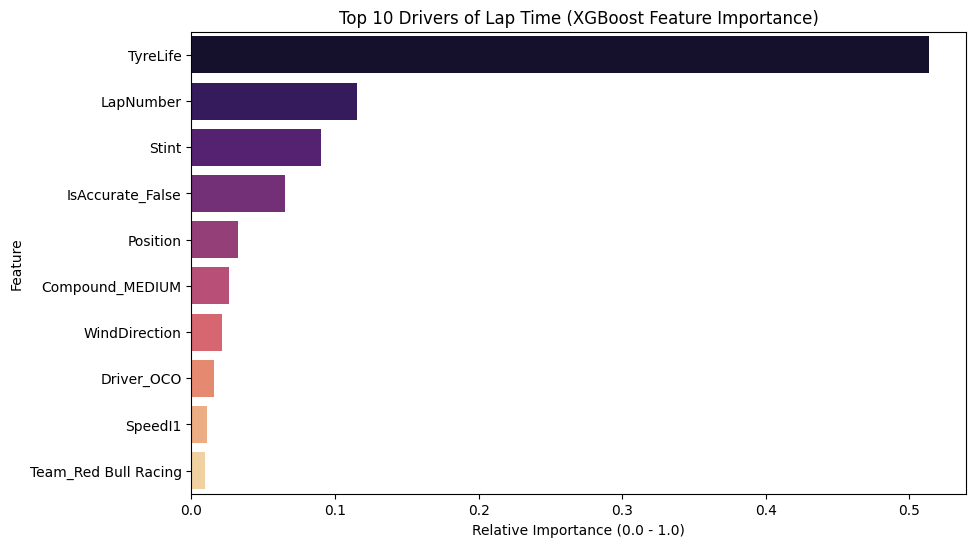

In [88]:
# FINAL VISUALIZATION & INTERPRETABILITY

# Model Comparison Plot (The Leaderboard)
# We visualize the R² scores to see the relative performance gap between models.
# We exclude the 'Baseline' because it is usually near 0 and distorts the scale.
if not df_results.empty:
    plt.figure(figsize=(10, 6))
    
    sns.barplot(
        data=df_results[df_results["Model"] != "Baseline"], # Filter out the dummy model
        x="R²",
        y="Model",
        palette="viridis" # A perceptually uniform color map
    )
    
    plt.title("Final Model Comparison (Test Set R² Score)")
    plt.xlabel("R² Score (Higher is Better)")
    
    plt.axvline(0.7, color="red", linestyle="--", label="Acceptable Threshold")
    plt.legend()
    plt.show()

# Feature Importance (Why did XGBoost win?)

try:
    # Step A: Reconstruct Feature Names
    # The Preprocessing Pipeline changed the number of columns.
    try:
        # Standard way for modern Scikit-Learn versions
        num_feature_names = preprocess.named_transformers_["num"].get_feature_names_out().tolist()
        cat_feature_names = preprocess.named_transformers_["cat"].get_feature_names_out().tolist()
        feature_names = num_feature_names + cat_feature_names
    except Exception:
        # Fallback if the pipeline structure is complex or sklearn version is old
        # We assign generic names F0, F1, F2... just to prevent crashing.
        feature_names = [f"F{i}" for i in range(xgb_core.n_features_in_)]

    # Step B: Extract Importance Values
    # XGBoost calculates importance based on how often a feature is used to make key splits.
    importances = xgb_core.feature_importances_

    # Create a DataFrame to sort and filter the top 10 most influential features
    df_imp = pd.DataFrame({
        "Feature": feature_names, 
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).head(10)

    # Step C: Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_imp, x="Importance", y="Feature", palette="magma")
    
    plt.title("Top 10 Drivers of Lap Time (XGBoost Feature Importance)")
    plt.xlabel("Relative Importance (0.0 - 1.0)")
    plt.show()

except Exception as e:
    print(f"Feature importance plot unavailable: {e}")

### Model Performance (R²)

- **Ridge** (~0.48): linear model, clearly not expressive enough.
- **Decision Tree** (~0.63): big gain → strong non-linear effects.
- **Random Forest** (~0.66): averaging many trees improves stability and accuracy.
- **XGBoost / Stacking / Voting** (> 0.70): best models, explain more than 70% of the variance.
- **Voting** is slightly ahead of XGBoost and Stacking, but the gain is small → diminishing returns.

Overall, tree-based ensembles and gradient boosting are much better suited than linear models for predicting F1 lap times.


### Top 10 Feature Importances (XGBoost)

- **TyreLife** is by far the most important feature → tyre degradation dominates lap-time behaviour.
- **LapNumber** and **Stint** capture race phase (fuel load, track evolution, strategy).
- **IsAccurate_False** separates clean laps from atypical ones (traffic, mistakes, lifts).
- **Position** and **Compound_MEDIUM** reflect overall pace and tyre compound choice.
- **WindDirection**, **Driver_OCO**, **Team_Alfa Romeo**, **SpeedI1** add secondary but useful information.

In short, lap time is mainly driven by tyres and race phase, with car/driver and conditions refining the prediction.
